<a href="https://colab.research.google.com/github/msilver22/GATr_arteries_classification/blob/main/dataset/dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-geometric -f https://data.pyg.org/whl/torch-1.9.0+cu102.html

Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu102.html


In [2]:
!pip install vtk

In [4]:
import h5py
import numpy as np
import torch
from torch_geometric.data import Data
import vtk
from vtkmodules.util.numpy_support import numpy_to_vtk, numpy_to_vtkIdTypeArray
import pyvista as pv
import matplotlib.pyplot as plt

In [5]:
def format_number(num):
    if num < 1000:
        return f'{num:04d}'
    else:
        return str(num)

In [6]:
ID = 765  # between 0 e 1999
sample_id = format_number(ID)
sample_name = f'sample_{sample_id}'
print("We are analyzing the",sample_name, "of the single_arteries database")

We are analyzing the sample_0765 of the single_arteries database


In [7]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/DEEP LEARNING/GATr project/app")
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DEEP LEARNING/GATr project/app


In [8]:
with h5py.File("/content/drive/My Drive/DEEP LEARNING/GATr project/stead_dataset/single/raw/database.hdf5", 'r') as hdf5_file:
    sample_0000_wss = hdf5_file[sample_name]['wss'][()]
print("The dimensions of wall shear stress data are", sample_0000_wss.shape)

with h5py.File("/content/drive/My Drive/DEEP LEARNING/GATr project/stead_dataset/single/raw/database.hdf5", 'r') as hdf5_file:
    sample_0000_pressure = hdf5_file[sample_name]['pressure'][()]
print("The dimensions of pressure data are",sample_0000_wss.shape)

with h5py.File("/content/drive/My Drive/DEEP LEARNING/GATr project/stead_dataset/single/raw/database.hdf5", 'r') as hdf5_file:
    sample_0000_pos = hdf5_file[sample_name]['pos'][()]
print("The dimensions of position data are", sample_0000_pos.shape)

with h5py.File("/content/drive/My Drive/DEEP LEARNING/GATr project/stead_dataset/single/raw/database.hdf5", 'r') as hdf5_file:
    sample_0000_face = hdf5_file[sample_name]['face'][()]
print("The dimensions of face data are",sample_0000_face.shape)

with h5py.File("/content/drive/My Drive/DEEP LEARNING/GATr project/stead_dataset/single/raw/database.hdf5", 'r') as hdf5_file:
    sample_0000_idcs = hdf5_file[sample_name]['inlet_idcs'][()]
print("The dimensions of inlet indeces data are",sample_0000_idcs.shape)

The dimensions of wall shear stress data are (9229, 3)
The dimensions of pressure data are (9229, 3)
The dimensions of position data are (9229, 3)
The dimensions of face data are (18454, 3)
The dimensions of inlet indeces data are (249,)


In [9]:
def hdf5_to_pyg(path_to_hdf5, sample_id):

    sample_name = f"sample_{sample_id:04d}"
    with h5py.File(path_to_hdf5, 'r') as f:

        # PyG Data object
        data = Data(
            wss=torch.from_numpy(f[sample_name]['wss'][()]),
            pos=torch.from_numpy(f[sample_name]['pos'][()]),
            face=torch.from_numpy(f[sample_name]['face'][()].T).long(),  # transpose to match PyG convention
            inlet_index=torch.from_numpy(f[sample_name]['inlet_idcs'][()])  # name "_index" for correct batching
        )

    return data

In [10]:
class VTUWriter():
    def __init__(self):
        self.vtu_writer = vtk.vtkXMLUnstructuredGridWriter()

    def __call__(self, path_to_file, data):

        self.vtu_writer.SetFileName(path_to_file)
        self.vtu_writer.SetInputData(self.pyg_to_vtk(data))

        self.vtu_writer.Update()

    def pyg_to_vtk(self, data):
        vtk_unstructured_grid = vtk.vtkUnstructuredGrid()

        vtk_points = vtk.vtkPoints()
        vtk_points.SetData(numpy_to_vtk(data.pos.numpy()))

        vtk_cell_array = vtk.vtkCellArray()
        vtk_cell_array.SetCells(data.face.shape[-1], numpy_to_vtkIdTypeArray(self.serialise_simplices(data.face)))

        vtk_unstructured_grid.SetPoints(vtk_points)
        vtk_unstructured_grid.SetCells(vtk.VTK_POLYGON, vtk_cell_array)

        vtk_unstructured_grid = self.add_point_data(vtk_unstructured_grid, data)

        return vtk_unstructured_grid
    @staticmethod
    def serialise_simplices(simplices):
        simplices = simplices.t().numpy()  # (3, N) to (N, 3)

        simplices = np.concatenate((
            np.full(simplices.shape[0], simplices.shape[1])[:, None],
            simplices
        ), axis=-1)

        return simplices.ravel()

    def add_point_data(self, vtk_unstructured_grid, data):
        for key, value in {**self.parse_point_data(data), **self.parse_point_indices(data)}.items():

            array = numpy_to_vtk(value)
            array.SetName(key)

            vtk_unstructured_grid.GetPointData().AddArray(array)

        return vtk_unstructured_grid

    @staticmethod
    def parse_point_data(data):
        return {key: value for key, value in data if value.size(0) == data.pos.size(0) and key != 'pos'}

    @staticmethod
    def parse_point_indices(data):
        point_mask_dict = {}

        for key, value in data:
            if "_index" in key and key != 'edge_index':

                point_mask = np.zeros(data.pos.size(0), dtype='i4')
                point_mask[value] = 1

                point_mask_dict[key.replace("_index", "")] = point_mask

        return point_mask_dict

In [11]:
vtu_writer = VTUWriter()
vtu_writer("random_sample.vtu", hdf5_to_pyg("/content/drive/My Drive/DEEP LEARNING/GATr project/stead_dataset/single/raw/database.hdf5", sample_id=ID))

We can represent the .vtu file using pyvista or other 3D visualisation packages. However, it is not possible to use pyvista on google colab because the mesh is perhaps too complicated for the means provided by google. The following image is a screenshot from the Paraview app.

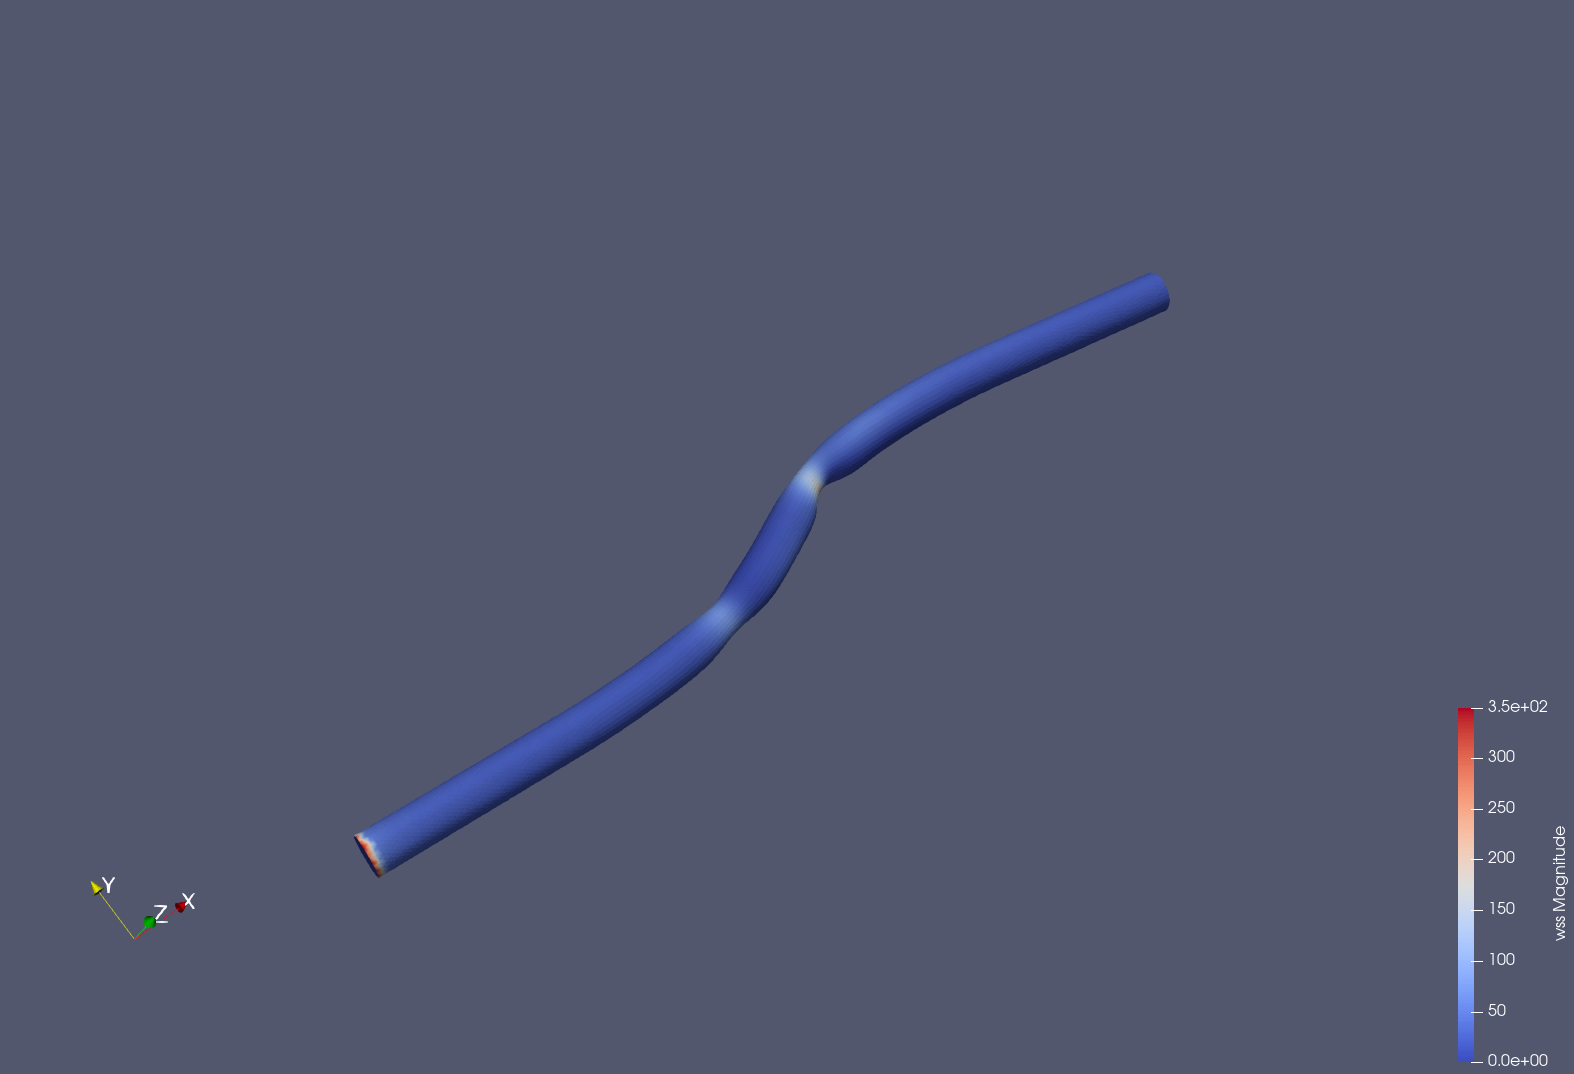